In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import xgboost as xgb

In [ ]:
def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  return data

In [ ]:
solar_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

**XGBoost**


**Approche univarié**

In [ ]:
Solar_Power=solar_data[['Power (MW)']].copy()
Wind_Power=wind_data[['Power (MW)']].copy()
#Split the data into train and test for solar data
train_S=Solar_Power[:int(len(solar_data)*0.8)]
test_S=Solar_Power[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W=Wind_Power[:int(len(wind_data)*0.8)]
test_W=Wind_Power[int(len(wind_data)*0.8):]
def Scaler(train,test):
 sc1=StandardScaler()
 sc2=StandardScaler()
 train_scaled=sc1.fit_transform(train)
 test_scaled=sc2.fit_transform(test)
 return train_scaled,test_scaled,sc1,sc2

train_S,test_S,sc_train_S,sc_test_S=Scaler(train_S,test_S)
train_W,test_W,sc_train_W,sc_test_W=Scaler(train_W,test_W)
#split to sequence for determine the step_inputs and the step_outputs

'''
The function split_sequences,
is a common approach for preparing time series data
 for multistep forecasting using a sequence-to-sequence model.
'''
def split_sequences(df,step_in=8,step_out=1):
 X,y=[],[]
 for i in range(step_in,len(df)-step_out):
  X.append(df[i-step_in:i])
  y.append(df[i+step_out])
 X=np.array(X)
 y=np.array(y)
 X =X.reshape((X.shape[0], -1))
 y =y.reshape(-1)
 return X,y
# for solar power
X_train_S,y_train_S=split_sequences(train_S,step_in=96,step_out=24)
X_test_S,y_test_S=split_sequences(test_S,step_in=96,step_out=24)
# for wind power
X_train_W,y_train_W=split_sequences(train_W,step_in=96,step_out=24)
X_test_W,y_test_W=split_sequences(test_W,step_in=96,step_out=24)

In [ ]:
X_train_S.shape

(56020, 96)

In [ ]:
def evalute_model(model,data,train,scaler,X_test,y_test,start,step_in,n_forecast,color_d):
 predictions=model.predict(X_test)
 #reshape
 predictions=predictions.reshape(-1,1)
 y_test=y_test.reshape(-1,1)
 #invesre scaler
 predictions=scaler.inverse_transform(predictions)
 y_test=scaler.inverse_transform(y_test)

 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+step_in+start+1],y_test[start:start+step_in+1],label='12 heures avant',color=color_d)
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+start+n_forecast+1],y_test[step_in+start:step_in+start+n_forecast+1],label='6 heures aprés',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+start+n_forecast+1],predictions[step_in+start:step_in+start+n_forecast+1],color='red',linestyle='dashed',label='prévision_XGBoost')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(y_test,predictions)
 mse=mean_squared_error(y_test,predictions)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(y_test,predictions)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)
 return predictions

In [ ]:
import os
import joblib
def save_model(model,model_path):

# Assuming you have trained the 'best_xgb_model'

# Remove the model file if it exists
 if os.path.exists(model_path):
    os.remove(model_path)
    joblib.dump(model, model_path)
 else:
    joblib.dump(model, model_path)

def load_model(model_path):
  model = joblib.load(model_path)
  return model



In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
def get_best_model(X_train,y_train,n_iter):
  param_space = {
    'n_estimators': range(50, 200),
    'max_depth': range(3, 15),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': range(1, 10)
    # Add more hyperparameters as needed
   }

  # Create XGBoost regressor
  xgb_model = xgb.XGBRegressor()

  # Define time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Define random search
  random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_space,
    n_iter=n_iter,  # Number of iterations
    scoring='neg_mean_squared_error',  # Use appropriate metric
    cv=tscv,
    verbose=1,
    n_jobs=-1
  )
  # Fit the random search to the data
  random_search.fit(X_train, y_train)

  best_xgb_model = xgb.XGBRegressor(**random_search.best_params_)
  best_xgb_model.fit(X_train, y_train)
  best_params_=random_search.best_params_

  return best_xgb_model,best_params_

In [ ]:
model_xgb_u_S,params_u_S=get_best_model(X_train_S,y_train_S,5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

In [ ]:
model_xgb_u_W,params_u_W=get_best_model(X_train_W,y_train_W,5)

In [ ]:
save_model(model_xgb_u_S,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_u_S.pkl')
model_xgb_u_S=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_u_S.pkl')

In [ ]:
save_model(model_xgb_u_W,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_u_W.pkl')
model_xgb_u_W=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_u_W.pkl')

mae= 5.145464413029148
mse= 50.1990152118519
rmse= 7.085126337042403
mape= 6561281026361502.0


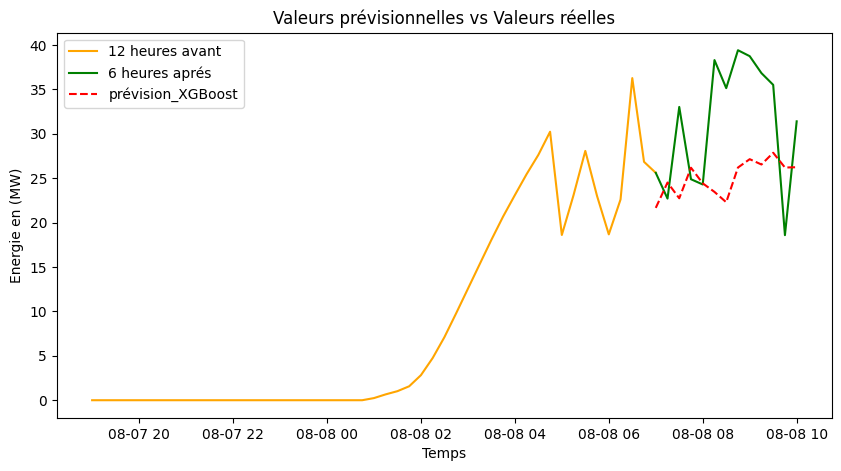

In [ ]:
prediction_Xgb_S=evalute_model(model_xgb_u_S,solar_data,train_S,sc_test_S,X_test_S,y_test_S,0,48,12,'orange')

mae= 17.120681717821356
mse= 449.42284780894386
rmse= 21.199595463332404
mape= 446821701149245.4


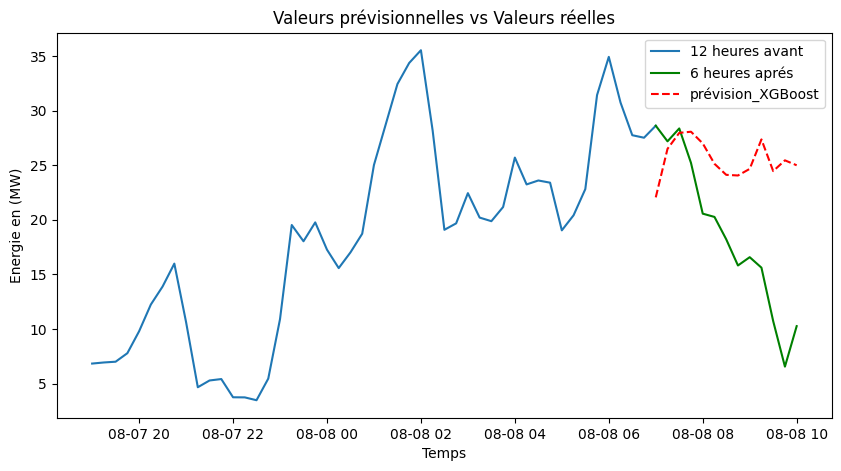

In [ ]:
prediction_Xgb_W=evalute_model(model_xgb_u_W,wind_data,train_W,sc_test_W,X_test_W,y_test_W,0,48,12,None)

**Approche multivarié**

In [ ]:
def filter_features_by_correlation(df, label_name):
    # Calculer la matrice de corrélation entre les features et le label
    correlation_matrix = df.corr()

    # Sélectionner la colonne de corrélation avec le label
    label_correlation = correlation_matrix[label_name]
    correlation_threshold = abs(label_correlation).mean()


    # Filtrer les features dont le coefficient de corrélation avec le label dépasse la valeur seuil
    correlated_features = label_correlation[abs(label_correlation) > correlation_threshold].index.tolist()
    data=df[correlated_features]

    return data

In [ ]:
solar_data_correlated=filter_features_by_correlation(solar_data,'Power (MW)')

In [ ]:
wind_data_correlated=filter_features_by_correlation(wind_data,'Power (MW)')

In [ ]:
#Split the data into train and test for solar data
train_S_m=solar_data_correlated[:int(len(solar_data)*0.8)]
test_S_m=solar_data_correlated[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W_m=wind_data_correlated[:int(len(wind_data)*0.8)]
test_W_m=wind_data_correlated[int(len(wind_data)*0.8):]

In [ ]:
#split to features and label
def split_features_label(data,label):
  label=data[[label]].copy()
  features=data.drop(label,axis=1)
  scaler=StandardScaler()
  features=scaler.fit_transform(features)
  label=scaler.fit_transform(label)
  return features,label,scaler

In [ ]:
train_features_S,train_label_S,scaler_train_s=split_features_label(train_S_m,'Power (MW)')
test_features_S,test_label_S,scaler_test_s=split_features_label(test_S_m,'Power (MW)')

train_features_W,train_label_W,scaler_train_w=split_features_label(train_W_m,'Power (MW)')
test_features_W,test_label_W,scaler_test_w=split_features_label(test_W_m,'Power (MW)')

In [ ]:
def split_sequences_2(features,label,step_in=960,step_out=12):
 X,y=[],[]
 for i in range(step_in,len(features)-step_out):
  X.append(features[i-step_in:i])
  y.append(label[i:i+step_out])
 X=np.array(X)
 y=np.array(y)
 X =X.reshape((X.shape[0],-1))
 y =y.reshape((y.shape[0],-1))
 return X,y

X_train_S_m,y_train_S_m=split_sequences_2(train_features_S,train_label_S,step_in=96,step_out=12)
X_test_S_m,y_test_S_m=split_sequences_2(test_features_S,test_label_S,step_in=96,step_out=12)


X_train_W_m,y_train_W_m=split_sequences_2(train_features_W,train_label_W,step_in=96,step_out=12)
X_test_W_m,y_test_W_m=split_sequences_2(test_features_W,test_label_W,step_in=96,step_out=12)

In [ ]:
X_train_S_m.shape

(56032, 288)

In [ ]:
model_xgb_m_S,params_m_S=get_best_model(X_train_S_m,y_train_S_m,5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

In [ ]:
model_xgb_m_W,params_m_W=get_best_model(X_train_W_m,y_train_W_m,5)

In [ ]:
save_model(model_xgb_m_S,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_m_S.pkl')
model_xgb_m_S=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_m_S.pkl')

In [ ]:
save_model(model_xgb_m_W,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_m_W.pkl')
model_xgb_m_W=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_xgb_m_W.pkl')

In [ ]:
prediction_Xgb_m_S=evalute_model(model_xgb_u_S,solar_data,train_S_m,scaler_test_s,X_test_S,y_test_S,0,48,12,'orange')

In [ ]:
prediction_Xgb_m__W=evalute_model(model_xgb_u_W,wind_data,train_W,scaler_test_w,X_test_W,y_test_W,0,48,12,None)